In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

In [9]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [10]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster
client

Client Scheduler: tcp://10.148.1.64:55827 Dashboard: http://10.148.1.64:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [11]:
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [12]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=2)

In [13]:
t0 = 1550
t1 = 1600
tmid = (t0+t1)/2
flt_id = 225

In [14]:
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [8]:
# Informations on drifter trajectory:
flti = flt1.loc[t0:t1]
latmin,latmax, lat0,lat1, latmid = flti.y.min(),flti.y.max(), flt1.loc[t0].y, flt1.loc[t1].y, flt1.loc[tmid].y
#print('Minimum latitude : ',latmin,';  Maximum latitude : ',latmax,';  Latitude at t0 : ', lat0,
#      ';  Laitude at t1 : ', lat1';  Latitude at tmid : ',latmid)

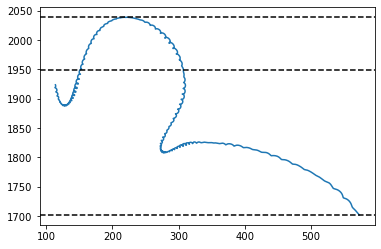

In [9]:
fig,ax  = plt.subplots()
ax.plot(flti.x,flti.y)
ax.axhline(y=latmax,c='k',linestyle='--')
ax.axhline(y=latmin,c='k',linestyle='--')
ax.axhline(y=latmid,c='k',linestyle='--')

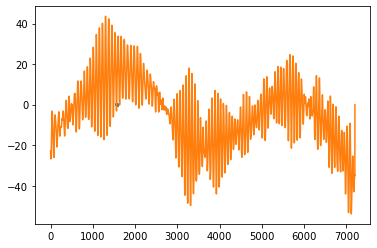

In [10]:
plt.plot(flti.v)
plt.plot(np.diff(flti.y)/0.007)

In [ ]:
eps = 1
flti.y[np.abs(flti.y-latmid)<eps].index

In [ ]:
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [ ]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [11]:
df0 = dr.df.groupby('time').get_group(flt1.index.min()).compute().sort_values('y').set_index('y')
#id0 = dr.df.groupby('time').get_group(flt1.index.min()).id

In [12]:
lat = [725,1215,1515,1715,2100]

In [13]:
DF0 = df0.to_xarray()#.sel(y=lat,method='nearest')

In [21]:
#DF0.sel(y=0,method='nearest')
yi = DF0.y[10::1800]
idi = DF0.id[10::1800]

In [ ]:
ds = {}
for i in idi[:2]:
    ds['flt_%s'%int(i.values)] = dr.df.groupby('id').get_group(int(i.values)).compute().sort_values('time').set_index('time').to_xarray()
ds

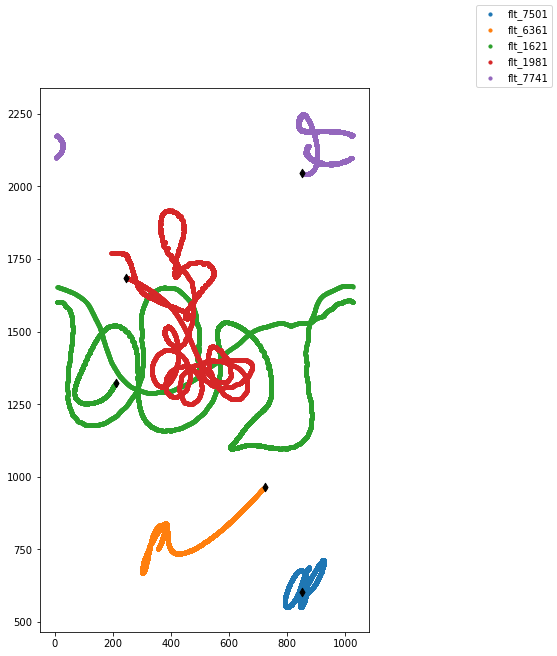

In [153]:
ti, tf = 1500,1600
fig,ax = plt.subplots(figsize=(10,10))
for d in ds :
    ax.scatter(ds['%s'%d].x.sel(time=slice(ti,tf)),ds['%s'%d].y.sel(time=slice(ti,tf)),
               s=10,label=str(d))
    ax.scatter(ds['%s'%d].x[0],ds['%s'%d].y[0],c='k',marker='d')
ax.set_aspect('equal')
fig.legend()

In [148]:
def diags_dist(flt,Ti,Tf):
    fltI = flt.sel(time=slice(Ti,Tf))
    return fltI.y.max().values,fltI.y.min().values,fltI.y[0].values,fltI.y[-1].values,fltI.v
def plot_dist(flt,Ti,Tf,figsize):
    fltI = flt.sel(time=slice(Ti,Tf))
    latmax,latmin, lat0,lat1, dydt = diags_dist(flt,Ti,Tf)
    fig = plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,2,1)
    ax.plot(fltI.x,fltI.y)
    ax.axhline(y=latmax,c='k',linestyle='--')
    ax.axhline(y=latmin,c='k',linestyle='--')
    ax.scatter(fltI.x[0],fltI.y[0],c='r')
    ax.set_ylabel(r'${y_\rho}$ (km)');ax.set_xlabel(r'${x_\rho}$ (km)')
    ax = fig.add_subplot(1,2,2)
    ax.plot(fltI.time,dydt)
    ax.set_ylabel('dy/dt');ax.set_xlabel('Time (days)')

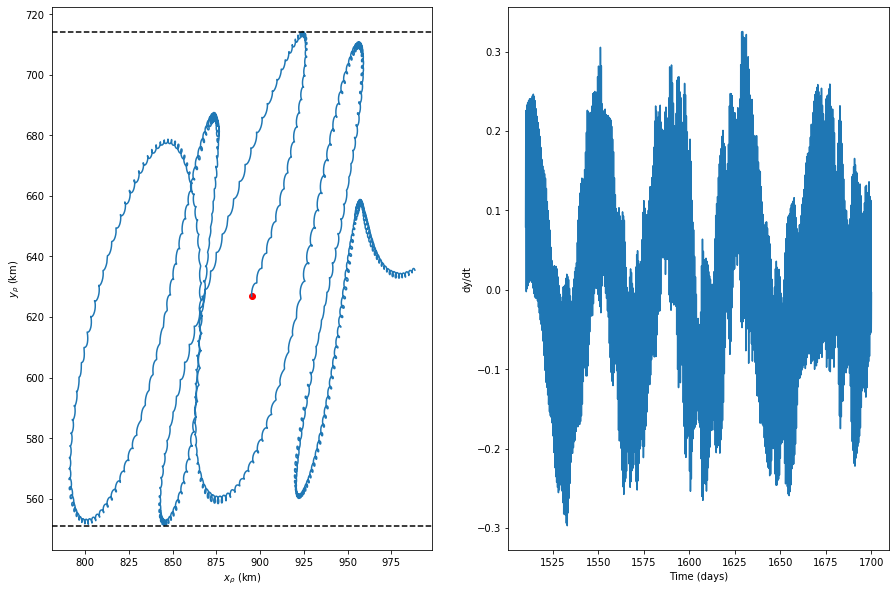

In [154]:
plot_dist(ds['flt_7501'],1510,1700,(15,10))

In [8]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
